# 1. Set up

### Download the data

In [ ]:
#Download data in the data folder
from azureml.core import Workspace, Dataset

subscription_id = '78b4d5f1-fca5-4af5-b686-34747c61c20f'
resource_group = 'ressource-group-Changins'
workspace_name = 'workspace-changins'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='oilseed-rape-dataset')
dataset.download(target_path='../../data/oilseed_rape', overwrite=True)

### General imports

In [20]:

import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms as T
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

In [17]:
from utils import plotImgs, CustomDataset

# 2. Data exploration

Before starting a model, it's always good have an overview of the data we work with. Especially, the class balance will be impacting the results. 

In [3]:
# Load images and masks
root = os.getcwd()
img_dir = root + '/../../data/oilseed_rape/train/Images'
img_paths = glob(img_dir + '/*')
mask_dir = root + '/../../data/oilseed_rape/train/Masks'
mask_paths = glob(mask_dir + '/*')

In [131]:
img = cv2.cvtColor(cv2.imread(img_paths[1]), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(mask_paths[1]), cv2.COLOR_BGR2RGB)

print('Data type:', type(img))
print('')
print('Data size')
print('Mask ([N, H, W]):', mask.shape)
print('Image ([N, C, H, W]):', img.shape)
print('')
print('Mask \n', mask[:4,:4])
print('')
print('Image \n', img[:4,:4])

Data type: <class 'numpy.ndarray'>

Data size
Mask ([N, H, W]): (1680, 2820, 3)
Image ([N, C, H, W]): (1680, 2820, 3)

Mask 
 [[[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]

Image 
 [[[ 90  87  70]
  [114 111  94]
  [ 93  88  69]
  [104  99  79]]

 [[ 77  74  57]
  [101  98  81]
  [ 96  90  74]
  [100  95  76]]

 [[ 64  62  47]
  [ 88  87  69]
  [ 99  96  79]
  [ 93  90  71]]

 [[ 47  45  32]
  [ 71  69  54]
  [ 96  93  78]
  [ 94  91  74]]]


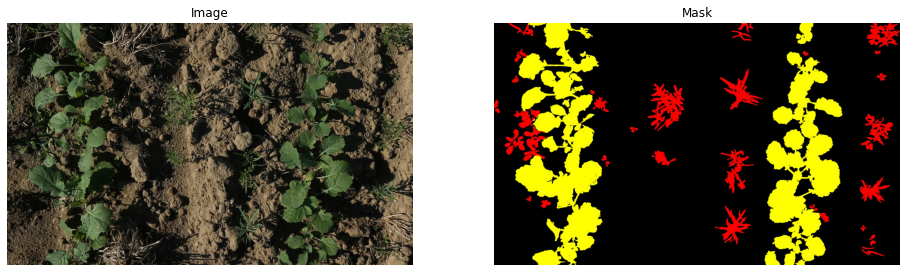

In [5]:
# A simple way to plot images
"""
plt.imshow(img)
plt.show()
""" 

# Nice plots with a function
plotImgs(1, 2, [img, mask], ['Image','Mask'])

# Stream data

In [91]:
class DatasetInfo:
    """ Class used to define all parameters and methods specific to the data sources (inputs and targets) """

    def __init__(self):

        # Get methods and parameters corresponding to input and target sources
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # parameterize the output(s)
        self.class_names = ['BG', 'SP', 'OSR']
        self.n_classes = 3
        
        self.dict_metrics = ['acc', 'prec', 'recall', 'f1', 'sup'] #add iou
        self.dict_attribute = self.class_names + ['Mean', 'FW']
        cols = []
        
        for a in self.dict_attribute:
            for m in self.dict_metrics:
                title = a + '_' + m
                cols.append(title)
        
        self.columns = ['Filename', 'Cov', 'Pred'] + cols
            
        # set patch parameters for inference
        self.num_patches_per_tile = 4 
        self.patch_size = 320 #256 min value size for windows using pretrained DeepLabv3+
        self.padding = 80
        self.stride = self.patch_size -  self.padding

    ################# Methods for pre/post-processing ######################### 
    
    def preprocess_input(self, inputs):
        #normalize image and convert to tensor
        transforms = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
        ])        
        return transforms(inputs)
    
    def preprocess_target(self, targets):
        
        #Create 3 classes, 0:BG, 1:SP, 2:OSR
        mask = np.zeros(targets.shape)
        mask[targets > 127] = 1              
        mask[mask[:, :, 1] > 0, 2] = 2
        
        return torch.from_numpy(mask[:, :, 2].astype(np.int64))
    
    def rescale(self, img):
        
        dim = (int(img.shape[1]//2), int(img.shape[0]//2))
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        
        return resized

    def create_kernel(self):
        k = np.ones((self.patch_size, self.patch_size), dtype=np.float32)
        k[self.padding//2:-self.padding//2, self.padding//2:-self.padding//2] = 5
        return k

    def get_inference_kernel(self):
        kernel = self.create_kernel()
        return kernel    
    
    

In [92]:
debug = True
batch_size = 4
num_epochs = 10
num_workers = 6
output_dir = root + '/output' 
input_dir = root + '/../../data/oilseed_rape' 

ds_info = DatasetInfo()

In [93]:
torch.cuda.empty_cache()

exp_name = os.path.basename(output_dir)
log_fn = os.path.join(output_dir, 'training','{}_metrics.pt'.format(exp_name))
model_fn = os.path.join(output_dir, 'training', '{}_model.pt'.format(exp_name))

In [94]:
############ Check other parameters ############
fn_val = [f[0] for f in pd.read_csv(root + '/dataset/validation_dataset.csv').values]
input_fns, target_fns = np.array(glob(input_dir + '/train/Images/*')), np.array(glob(input_dir + '/train/Masks/*'))
    
cond = [t.split('/')[-1].split('.')[0] in fn_val for t in target_fns]
    
input_fns_val, target_fns_val = input_fns[cond], target_fns[cond]
input_fns, target_fns = input_fns[np.invert(cond)], target_fns[np.invert(cond)]

# load checkpoints if resuming training from existing model
save_dict = {
    'train_losses': [],
    'model_checkpoints': [],
    'optimizer_checkpoints' : [],
    'train_reports':[],
    'val_reports' : [],
    'val_losses':[],
    'epochs' : []
    }

In [95]:
# for debugging: use subset of training set
if debug:
    input_fns = input_fns[:10]
    target_fns = target_fns[:3]

In [96]:
dataset = CustomDataset(
            input_fns = input_fns, 
            target_fns = target_fns, 
            dataset_info = ds_info,
            verbose=False
        )

print('Length training dataset', len(input_fns))
print('Length validation dataset', len(input_fns_val))

Length training dataset 10
Length validation dataset 5


In [97]:
# create dataloader
print('Creating dataloader...')
dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size = batch_size,
            num_workers = num_workers,
            pin_memory=True,
        )

Creating dataloader...


In [116]:
data, target = next(iter(dataloader))

In [125]:
print('Data type:', type(data))
print('')
print('Data size')
print('Mask from dataloader ([N, H, W]):', target.shape)
print('Image from dataloader ([N, C, H, W]):', data.shape)
print('')
print('Mask from dataloader \n', target[0,:4,:4])

print('Image from dataloader \n', data[0,:,:4,:4])


Data type: <class 'torch.Tensor'>

Data size
Mask from dataloader ([N, H, W]): torch.Size([4, 320, 320])
Image from dataloader ([N, C, H, W]): torch.Size([4, 3, 320, 320])

Mask from dataloader 
 tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])
Image from dataloader 
 tensor([[[-1.9124, -1.9638, -1.9638, -1.9124],
         [-1.9467, -1.9809, -1.9638, -1.9124],
         [-1.9467, -1.9809, -1.9295, -1.8782],
         [-1.9638, -1.9809, -1.9295, -1.8610]],

        [[-1.8256, -1.8782, -1.8782, -1.7906],
         [-1.8256, -1.8606, -1.8431, -1.7906],
         [-1.8256, -1.8606, -1.8081, -1.7556],
         [-1.8431, -1.8606, -1.8081, -1.7381]],

        [[-1.6302, -1.6824, -1.6824, -1.5779],
         [-1.6476, -1.6824, -1.6650, -1.5779],
         [-1.6476, -1.6824, -1.6302, -1.5430],
         [-1.6999, -1.6824, -1.6302, -1.5604]]])


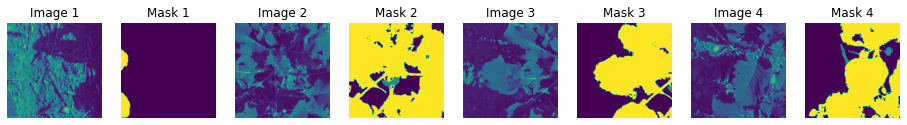

In [121]:
plotImgs(1,8,[img[0,0], mask[0]*127, img[1,0], mask[1]*127, img[2,0], mask[2]*127, img[3,0], mask[3]*127], 
    ['Image 1','Mask 1', 'Image 2','Mask 2', 'Image 3','Mask 3', 'Image 4','Mask 4'])

## Create the model

In [21]:
#Load pretrained model
model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)

#Auxiliaire classifier is modified according to number of class to predict
model.classifier = DeepLabHead(2048, ds_info.n_classes)

# Set the model in training mode
model.train()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [22]:
# Set model architecture
# Create model and criterion, and forward + backward pass function
model = model.to(ds_info.device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
n_batches_per_epoch = int(len(dataset.fns) * ds_info.num_patches_per_tile / batch_size)
Infer = utils.Inference(model, ds_info, output_dir)